In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [26]:
pipe = Pipeline([('reduce_dim',PCA()), ('classify',LinearSVC())])

n_features_options = [2,4,8]
c_options = [1,10,100,1000] #惩罚系数，即对误差的宽容度，值越高表示对误差越不能容忍

param_grid = [
    {
        'reduce_dim':[PCA(iterated_power=7),NMF()], # iterated_power:Number of iterations for the power method computed by svd_solver == ‘randomized’
        'reduce_dim__n_components':n_features_options,
        'classify__C':c_options
    },
    {
        'reduce_dim':[SelectKBest(chi2)], #chi2卡方检验：检验定性自变量对定性因变量的相关性
        'reduce_dim__k':n_features_options,
        'classify__C':c_options
    }
]

reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

In [27]:
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid) 
# n_jobs: 并行数，int：个数,-1：跟CPU核数一致, 1:默认值。
digits = load_digits()
grid.fit(digits.data, digits.target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, ver...ction chi2 at 0x00000256E89C16A8>)], 'reduce_dim__k': [2, 4, 8], 'classify__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scorin

In [23]:
grid.best_estimator_

Pipeline(memory=Memory(cachedir='C:\\Users\\sunqu\\AppData\\Local\\Temp\\tmp1y8g_kir\\joblib'),
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [30]:
grid.cv_results_['mean_test_score'].shape  #总共36组参数组合

(36,)

In [32]:
"""cv_results_ : dict of numpy (masked) ndarrays
A dict with keys as column headers and values as columns, that can be imported into 
a pandas DataFrame."""

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(c_options), -1, len(n_features_options))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(n_features_options))*(len(reducer_labels)+1)+0.5)
bar_offsets

array([0.5, 4.5, 8.5])

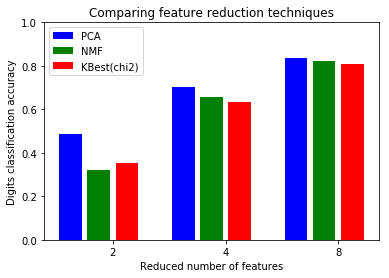

In [17]:
plt.figure()
colors = 'bgrcmyk'
for i,(label,reducer_scores) in enumerate(zip(reducer_labels,mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=colors[i])
    
plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, n_features_options)
plt.ylabel('Digits classification accuracy')
plt.ylim((0,1))
plt.legend(loc='upper left')

Caching transformers within a Pipeline

In [18]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

In [19]:
# create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
cached_pipe = Pipeline([('reduce_dim', PCA()),('classify', LinearSVC())],
                      memory=memory)

# this time, a cached pipeline will be used within the grid search
grid = GridSearchCV(cached_pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data,digits.target)

#delete the temporary cache before exiting
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\0dfb8827082f6f898ef973ed61811b1a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\1721bb7cea2ebf6ad0a8e6d280e892c1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\0ceb05366ee768cc50e60e1613d1a0bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\69082e42d83b174b755f331c8f1b0c21
___________________________________fi

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\2163979f8172759105dad88a77adc5d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\ad53d9483ada5853420a2e7a03b9c81e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\902b912d148161c76618e805ef893a3e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\0bd4a2dd53c6526dc309a288d1a6efb6
___________________________________fi

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x00000256E89C16A8>), None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x00000256E89C16A8>), None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]))
________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from C:\Users\sunqu\AppData\Local\Temp\tmp1y8g_kir\joblib\sklearn\pipeline\_fit_transform_one\0a70c9565493e41d33e0e2f2628a636c
___________________________________fit_tra